In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
import scikit_posthocs

# When we only wanted to rank between ligands

#### Looking at just the first example

In [40]:
regressor_performance_df = pd.read_excel("performance_excels/regressor_performance_1.xlsx")
labelranking_performance_df = pd.read_excel("performance_excels/label_ranking_performance_1.xlsx")
baseline_performance_df = pd.read_excel("performance_excels/baseline_performance_1.xlsx")

In [45]:
reg_halOOS_kt = regressor_performance_df[
    regressor_performance_df["OOS"] == "halide"
]["Kendall"].values
base_halOOS_kt = baseline_performance_df[
    regressor_performance_df["OOS"] == "halide"
]["Kendall"].values
rpc_halOOS_kt = labelranking_performance_df[
    (labelranking_performance_df["OOS"] == "halide") &\
    (labelranking_performance_df["Model"] == "Pairwise")
]["Kendall"].values
lrrf_halOOS_kt = labelranking_performance_df[
    (labelranking_performance_df["OOS"] == "halide") &\
    (labelranking_performance_df["Model"] == "LRRF")
]["Kendall"].values

In [46]:
print(np.mean(reg_halOOS_kt))
print(np.mean(base_halOOS_kt[~np.isnan(base_halOOS_kt)]))
print(np.mean(rpc_halOOS_kt[~np.isnan(rpc_halOOS_kt)]))
print(np.mean(lrrf_halOOS_kt[~np.isnan(lrrf_halOOS_kt)]))

0.41239316239316254
0.4597738031787114
0.198081074681063
0.09973075784002561


In [49]:
for oos in ["halide", "additive", "both"]:
    print(f"When {oos} is OOS")
    reg_halOOS_rank = regressor_performance_df[
        regressor_performance_df["OOS"] == oos
    ]["Top Rank"].values
    base_halOOS_rank = baseline_performance_df[
        regressor_performance_df["OOS"] == oos
    ]["Top Rank"].values
    rpc_halOOS_rank = labelranking_performance_df[
        (labelranking_performance_df["OOS"] == oos) &\
        (labelranking_performance_df["Model"] == "Pairwise")
    ]["Top Rank"].values
    lrrf_halOOS_rank = labelranking_performance_df[
        (labelranking_performance_df["OOS"] == oos) &\
        (labelranking_performance_df["Model"] == "LRRF")
    ]["Top Rank"].values

    for rank_array in [reg_halOOS_rank, base_halOOS_rank,rpc_halOOS_rank, lrrf_halOOS_rank]:
        print(np.mean(np.reciprocal(rank_array)))
    print()

When halide is OOS
0.46794871794871795
0.5256410256410257
0.6730769230769231
0.532051282051282

When additive is OOS
0.6574074074074074
0.5092592592592593
0.8333333333333334
0.7870370370370371

When both is OOS
0.5626780626780626
0.5612535612535613
0.6794871794871795
0.5185185185185185



### Comparing LRRF with adversarial features

In [19]:
labelranking_performance_df = pd.read_excel("performance_excels/label_ranking_performance_20_dft_9tests.xlsx")
lr_random_df = pd.read_excel("performance_excels/label_ranking_performance_20_random_9tests.xlsx")
lr_onehot_df = pd.read_excel("performance_excels/label_ranking_performance_20_onehot_9tests.xlsx")

In [24]:
lr_random_df = lr_random_df[lr_random_df["Model"]=="LRRF"]
lr_onehot_df = lr_onehot_df[lr_onehot_df["Model"]=="LRRF"]
lr_dft_df = labelranking_performance_df[labelranking_performance_df["Model"]=="LRRF"]

In [29]:
lr_dft_df

,Unnamed: 0,Number of test reactants,Train halides,Train additives,Model,OOS,Kendall,Top Rank,Test halide,Test additive
846,846,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,0.333333,1,1-bromo-4-(trifluoromethyl)benzene,3-methyl-5-phenylisoxazole
847,847,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,0.666667,1,1-bromo-4-(trifluoromethyl)benzene,3-methyl-5-phenylisoxazole
848,848,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,1.000000,1,1-bromo-4-(trifluoromethyl)benzene,3-methyl-5-phenylisoxazole
849,849,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,0.333333,1,1-bromo-4-(trifluoromethyl)benzene,3-methylisoxazole
850,850,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,-0.333333,4,1-bromo-4-(trifluoromethyl)benzene,3-methylisoxazole
...,...,...,...,...,...,...,...,...,...,...
49909,49909,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,-0.333333,3,3-iodopyridine,methyl-5-(furan-2-yl)isoxazole-3-carboxylate
49910,49910,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,0.333333,1,3-iodopyridine,methyl-5-(furan-2-yl)isoxazole-3-carboxylate
49911,49911,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,0.666667,1,3-iodopyridine,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate
49912,49912,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,0.333333,2,3-iodopyridine,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate


In [28]:
lr_random_df

,Unnamed: 0,Number of test reactants,Train halides,Train additives,Model,OOS,Kendall,Top Rank,Test halide,Test additive
846,846,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,0.666667,1,1-bromo-4-(trifluoromethyl)benzene,3-methyl-5-phenylisoxazole
847,847,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,0.333333,2,1-bromo-4-(trifluoromethyl)benzene,3-methyl-5-phenylisoxazole
848,848,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,1.000000,1,1-bromo-4-(trifluoromethyl)benzene,3-methyl-5-phenylisoxazole
849,849,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,0.666667,1,1-bromo-4-(trifluoromethyl)benzene,3-methylisoxazole
850,850,9,"('1-chloro-4-(trifluoromethyl)benzene', '1-chl...","('3-methyl-5-phenylisoxazole', '3-methylisoxaz...",LRRF,halide,0.000000,1,1-bromo-4-(trifluoromethyl)benzene,3-methylisoxazole
...,...,...,...,...,...,...,...,...,...,...
49909,49909,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,-0.333333,3,3-iodopyridine,methyl-5-(furan-2-yl)isoxazole-3-carboxylate
49910,49910,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,0.333333,1,3-iodopyridine,methyl-5-(furan-2-yl)isoxazole-3-carboxylate
49911,49911,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,0.666667,1,3-iodopyridine,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate
49912,49912,9,"('1-bromo-4-ethylbenzene', '1-chloro-4-(triflu...","('3,5-dimethylisoxazole', '3-methyl-5-phenylis...",LRRF,both,0.333333,2,3-iodopyridine,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate


In [30]:
train_halide_additive_pairs = list(set(
    [(x,y) for (x,y) in list(lr_dft_df[["Train halides", "Train additives"]].itertuples(index=False, name=None))]
))

oos_component = ["halide", "additive", "both"]

kt_vals = [np.zeros((4,20)), np.zeros((4,20)), np.zeros((4,20))] # rows in order of baseline, regressor, RPC, LRRF # 3rd axis for OOS, in order of halide additive both
mrr_vals = [np.zeros((4,20)), np.zeros((4,20)), np.zeros((4,20))]

score_dict = {
    "OOS":[],
    "Kendall-Tau":[],
    "Mean Reciprocal Ranking":[],
    "Feature":[]
}

def score_array_to_update(score_array, feature, oos):
    kt = score_array[:,0]
    top_rank = score_array[:,1]
    score_dict["OOS"].append(oos)
    score_dict["Feature"].append(feature)
    score_dict["Kendall-Tau"].append(np.mean(kt[~np.isnan(kt)]))
    score_dict["Mean Reciprocal Ranking"].append(np.mean(np.reciprocal(top_rank)))


for i, (halide, additive) in enumerate(train_halide_additive_pairs) :
    for j, oos in enumerate(oos_component) :
        # for k, (df, feature_name) in enumerate(zip([lr_random_df, lr_onehot_df, lr_dft_df], ["Random","OneHot","DFT"])) :
            # if k < 2 :
            #     scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)][["Kendall", "Top Rank"]].to_numpy()
            #     score_array_to_update(scores, feature_name, oos)
            # else :
        random_scores = lr_random_df[(lr_random_df["OOS"]==oos)&(lr_random_df["Train halides"]==halide)&(lr_random_df["Train additives"]==additive)][["Kendall", "Top Rank"]].to_numpy()
        print(random_scores)
        onehot_scores = lr_onehot_df[(lr_onehot_df["OOS"]==oos)&(lr_onehot_df["Train halides"]==halide)&(lr_onehot_df["Train additives"]==additive)][["Kendall", "Top Rank"]].to_numpy()
        dft_scores = lr_dft_df[(lr_dft_df["OOS"]==oos)&(lr_dft_df["Train halides"]==halide)&(lr_dft_df["Train additives"]==additive)][["Kendall", "Top Rank"]].to_numpy()
        score_array_to_update(random_scores, "Random", oos)
        score_array_to_update(onehot_scores, "OneHot", oos)
        score_array_to_update(dft_scores, "DFT", oos)

[[ 0.33333333  1.        ]
 [ 0.66666667  1.        ]
 [ 0.66666667  1.        ]
 [ 0.          2.        ]
 [ 0.66666667  1.        ]
 [-0.33333333  2.        ]
 [ 0.70710678  1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 0.66666667  1.        ]
 [ 1.          1.        ]
 [ 0.66666667  1.        ]
 [ 0.33333333  1.        ]
 [ 0.66666667  1.        ]
 [ 0.66666667  1.        ]
 [ 0.66666667  2.        ]
 [ 0.          3.        ]
 [ 0.33333333  3.        ]
 [ 0.66666667  1.        ]
 [ 0.66666667  1.        ]
 [        nan  4.        ]
 [-0.54772256  4.        ]
 [ 0.          2.        ]
 [ 0.66666667  2.        ]
 [ 0.          3.        ]
 [ 0.33333333  2.        ]
 [ 1.          1.        ]
 [ 0.          3.        ]
 [ 0.66666667  1.        ]
 [ 0.          3.        ]
 [ 0.23570226  4.        ]
 [ 0.23570226  4.        ]
 [ 0.66666667  1.        ]
 [ 0.33333333  2.        ]
 [ 0.33333333  2.        ]
 [ 0.33333333  3.        ]
 [ 0.33333333  2.        ]
 

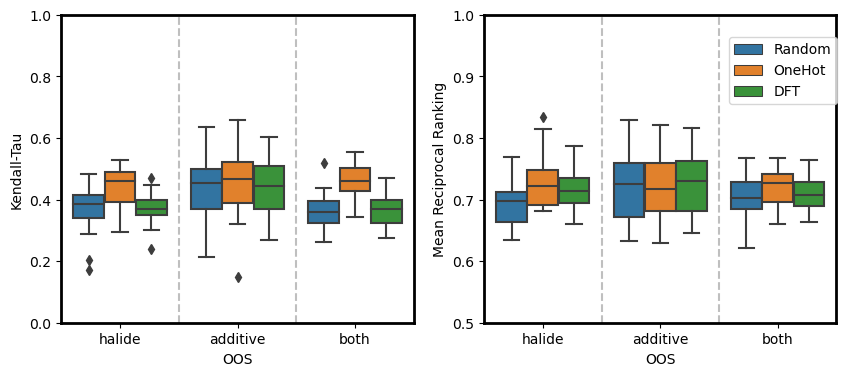

In [31]:
score_df = pd.DataFrame(score_dict)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
sns.boxplot(data=score_df, x="OOS", y="Kendall-Tau", hue="Feature", ax=ax[0])
sns.boxplot(data=score_df, x="OOS", y="Mean Reciprocal Ranking", hue="Feature", ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.02,0.95))
ax[1].set_ylim(0.5,1)
ax[1].set_yticks([0.1*x for x in range(5,11)])
ax[1].set_yticklabels([round(0.1*x,1) for x in range(5,11)])
ax[0].set_yticks([0.2*x for x in range(6)])
ax[0].set_yticklabels([round(0.2*x,1) for x in range(6)])
for i in range(2):
    ax[i].axvline(0.5,0,1,c="grey",ls='--',alpha=0.5)
    ax[i].axvline(1.5,0,1,c="grey",ls='--',alpha=0.5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(2)

### Now with 20 randomly selected training sets

In [16]:
regressor_performance_df = pd.read_excel("performance_excels/regressor_performance_20_11tests.xlsx")
# labelranking_performance_df = pd.read_excel("performance_excels/label_ranking_performance_20_dft.xlsx")
labelranking_performance_df = pd.read_excel("performance_excels/label_ranking_performance_20_dft_11tests.xlsx")
baseline_performance_df = pd.read_excel("performance_excels/baseline_performance_20_11tests.xlsx")

In [17]:
train_halide_additive_pairs = list(set(
    [(x,y) for (x,y) in list(labelranking_performance_df[["Train halides", "Train additives"]].itertuples(index=False, name=None))]
))

oos_component = ["halide", "additive", "both"]

kt_vals = [np.zeros((4,20)), np.zeros((4,20)), np.zeros((4,20))] # rows in order of baseline, regressor, RPC, LRRF # 3rd axis for OOS, in order of halide additive both
mrr_vals = [np.zeros((4,20)), np.zeros((4,20)), np.zeros((4,20))]

score_dict = {
    "OOS":[],
    "Kendall-Tau":[],
    "Mean Reciprocal Ranking":[],
    "Algorithm":[]
}

def score_array_to_update(score_array, model, oos):
    kt = score_array[:,0]
    top_rank = score_array[:,1]
    score_dict["OOS"].append(oos)
    score_dict["Algorithm"].append(model)
    score_dict["Kendall-Tau"].append(np.mean(kt[~np.isnan(kt)]))
    score_dict["Mean Reciprocal Ranking"].append(np.mean(np.reciprocal(top_rank)))


for i, (halide, additive) in enumerate(train_halide_additive_pairs) :
    for j, oos in enumerate(oos_component) :
        for k, (df, model_name) in enumerate(zip([baseline_performance_df, regressor_performance_df, labelranking_performance_df], ["Avg. Yield","RFRegressor",""])) :
            if k < 2 :
                scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)][["Kendall", "Top Rank"]].to_numpy()
                score_array_to_update(scores, model_name, oos)
            else :
                rpc_scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)&(df["Model"]=="Pairwise")][["Kendall", "Top Rank"]].to_numpy()
                lrrf_scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)&(df["Model"]=="LRRF")][["Kendall", "Top Rank"]].to_numpy()
                lrt_scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)&(df["Model"]=="LRT")][["Kendall", "Top Rank"]].to_numpy()
                score_array_to_update(rpc_scores, "RPC", oos)
                score_array_to_update(lrrf_scores, "LRRF", oos)
                score_array_to_update(lrt_scores, "LRT", oos)

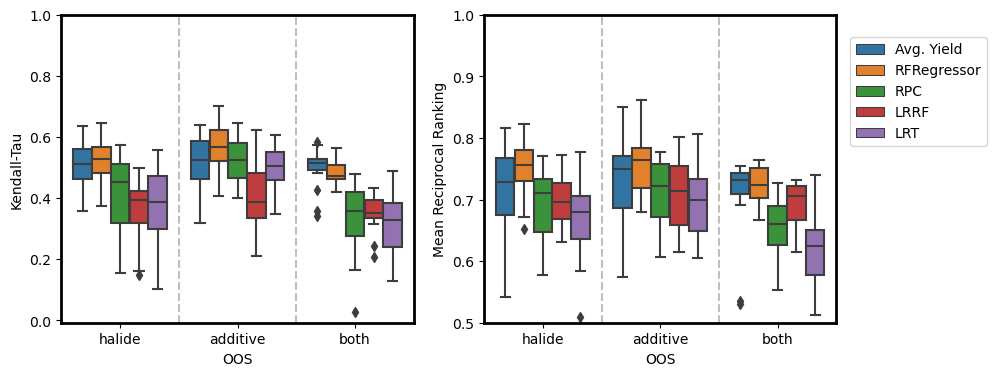

In [18]:
score_df = pd.DataFrame(score_dict)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
sns.boxplot(data=score_df, x="OOS", y="Kendall-Tau", hue="Algorithm", ax=ax[0])
sns.boxplot(data=score_df, x="OOS", y="Mean Reciprocal Ranking", hue="Algorithm", ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.02,0.95))
ax[1].set_ylim(0.5,1)
ax[1].set_yticks([0.1*x for x in range(5,11)])
ax[1].set_yticklabels([round(0.1*x,1) for x in range(5,11)])
ax[0].set_yticks([0.2*x for x in range(6)])
ax[0].set_yticklabels([round(0.2*x,1) for x in range(6)])
for i in range(2):
    ax[i].axvline(0.5,0,1,c="grey",ls='--',alpha=0.5)
    ax[i].axvline(1.5,0,1,c="grey",ls='--',alpha=0.5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(2)

#### Now with 20 randomly selected training sets

In [2]:
regressor_performance_df = pd.read_excel("performance_excels/regressor_performance_20.xlsx")
labelranking_performance_df = pd.read_excel("performance_excels/label_ranking_performance_20.xlsx")
baseline_performance_df = pd.read_excel("performance_excels/baseline_performance_20.xlsx")

In [4]:
train_halide_additive_pairs = list(set(
    [(x,y) for (x,y) in list(labelranking_performance_df[["Train halides", "Train additives"]].itertuples(index=False, name=None))]
))

oos_component = ["halide", "additive", "both"]

kt_vals = [np.zeros((4,20)), np.zeros((4,20)), np.zeros((4,20))] # rows in order of baseline, regressor, RPC, LRRF # 3rd axis for OOS, in order of halide additive both
mrr_vals = [np.zeros((4,20)), np.zeros((4,20)), np.zeros((4,20))]

score_dict = {
    "OOS":[],
    "Kendall-Tau":[],
    "Mean Reciprocal Ranking":[],
    "Algorithm":[]
}

def score_array_to_update(score_array, model, oos):
    kt = score_array[:,0]
    top_rank = score_array[:,1]
    score_dict["OOS"].append(oos)
    score_dict["Algorithm"].append(model)
    score_dict["Kendall-Tau"].append(np.mean(kt[~np.isnan(kt)]))
    score_dict["Mean Reciprocal Ranking"].append(np.mean(np.reciprocal(top_rank)))


for i, (halide, additive) in enumerate(train_halide_additive_pairs) :
    for j, oos in enumerate(oos_component) :
        for k, (df, model_name) in enumerate(zip([baseline_performance_df, regressor_performance_df, labelranking_performance_df], ["Avg. Yield","RFRegressor",""])) :
            if k < 2 :
                scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)][["Kendall", "Top Rank"]].to_numpy()
                score_array_to_update(scores, model_name, oos)
            else :
                rpc_scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)&(df["Model"]=="Pairwise")][["Kendall", "Top Rank"]].to_numpy()
                lrrf_scores = df[(df["OOS"]==oos)&(df["Train halides"]==halide)&(df["Train additives"]==additive)&(df["Model"]=="LRRF")][["Kendall", "Top Rank"]].to_numpy()
                score_array_to_update(rpc_scores, "RPC", oos)
                score_array_to_update(lrrf_scores, "LRRF", oos)

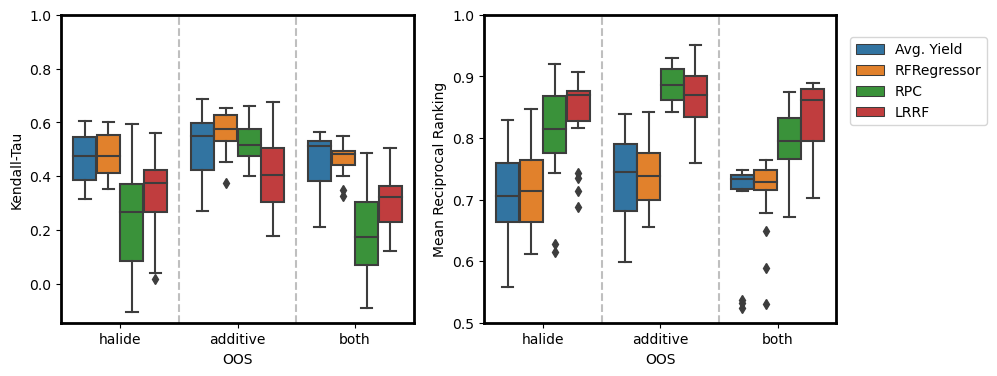

In [13]:
score_df = pd.DataFrame(score_dict)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
sns.boxplot(data=score_df, x="OOS", y="Kendall-Tau", hue="Algorithm", ax=ax[0])
sns.boxplot(data=score_df, x="OOS", y="Mean Reciprocal Ranking", hue="Algorithm", ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.02,0.95))
ax[1].set_ylim(0.5,1)
ax[1].set_yticks([0.1*x for x in range(5,11)])
ax[1].set_yticklabels([round(0.1*x,1) for x in range(5,11)])
ax[0].set_yticks([0.2*x for x in range(6)])
ax[0].set_yticklabels([round(0.2*x,1) for x in range(6)])
for i in range(2):
    ax[i].axvline(0.5,0,1,c="grey",ls='--',alpha=0.5)
    ax[i].axvline(1.5,0,1,c="grey",ls='--',alpha=0.5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(2)

In [17]:
for oos in oos_component :
    _, p = friedmanchisquare(
        score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="Avg. Yield")]["Mean Reciprocal Ranking"].values,
        score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="RFRegressor")]["Mean Reciprocal Ranking"].values,
        score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="RPC")]["Mean Reciprocal Ranking"].values,
        score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="LRRF")]["Mean Reciprocal Ranking"].values
    )
    print(oos, p)
    if p < 0.01 :
        posthoc_p = scikit_posthocs.posthoc_nemenyi_friedman(np.vstack((
            score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="Avg. Yield")]["Mean Reciprocal Ranking"].values,
            score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="RFRegressor")]["Mean Reciprocal Ranking"].values,
            score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="RPC")]["Mean Reciprocal Ranking"].values,
            score_df[(score_df["OOS"]==oos)&(score_df["Algorithm"]=="LRRF")]["Mean Reciprocal Ranking"].values
        )).T)
        print("Posthoc Nemenyi test:", posthoc_p)
    print()

halide 3.081530279878794e-09
Posthoc Nemenyi test:           0         1         2         3
0  1.000000  0.597695  0.001000  0.001000
1  0.597695  1.000000  0.011807  0.001000
2  0.001000  0.011807  1.000000  0.457254
3  0.001000  0.001000  0.457254  1.000000

additive 1.0566582100177156e-09
Posthoc Nemenyi test:           0         1         2         3
0  1.000000  0.900000  0.001000  0.001076
1  0.900000  1.000000  0.001000  0.002718
2  0.001000  0.001000  1.000000  0.255934
3  0.001076  0.002718  0.255934  1.000000

both 2.39636590131049e-06
Posthoc Nemenyi test:           0         1         2         3
0  1.000000  0.528951  0.002169  0.001000
1  0.528951  1.000000  0.122139  0.002169
2  0.002169  0.122139  1.000000  0.528951
3  0.001000  0.002169  0.528951  1.000000



## When both ligand and base were considered as reaction condition

In [4]:
regressor_performance_df = pd.read_excel("performance_excels/doyle_ligandXbase/regressor_performance.xlsx")
labelranking_performance_df = pd.read_excel("performance_excels/doyle_ligandXbase/rpc_performance.xlsx")
# baseline_performance_df = pd.read_excel("performance_excels/regressor_performance.xlsx")

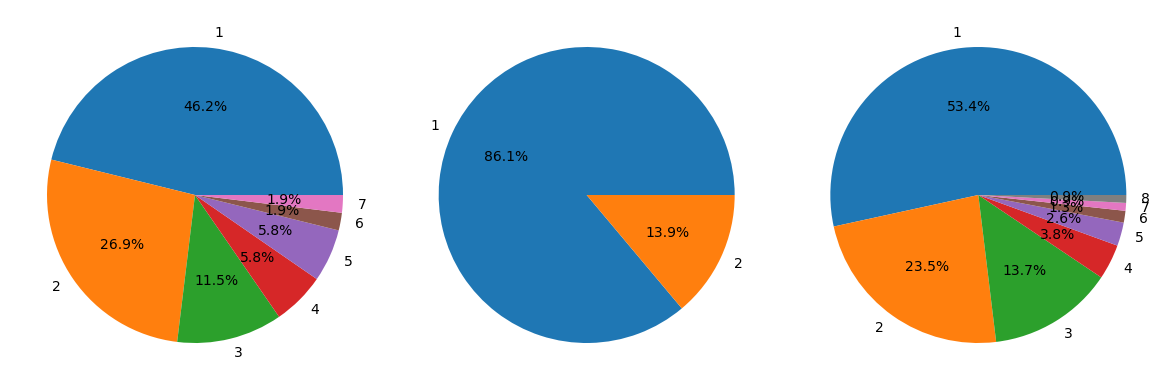

In [3]:
fig, ax = plt.subplots(ncols=3, tight_layout=True, figsize=(12,4))

for i, oos in enumerate(["halide", "additive", "both"]) :
    ranks = regressor_performance_df[
        regressor_performance_df["OOS"] == oos
    ]["Top Rank"]
    sizes = [len(np.where(ranks == x)[0]) for x in sorted(ranks.unique())]
    labels = sorted(ranks.unique())
    ax[i].pie(sizes, labels=labels, autopct='%1.1f%%')
    # ax[i].set_title(f"{oos} out-of-training-sample")

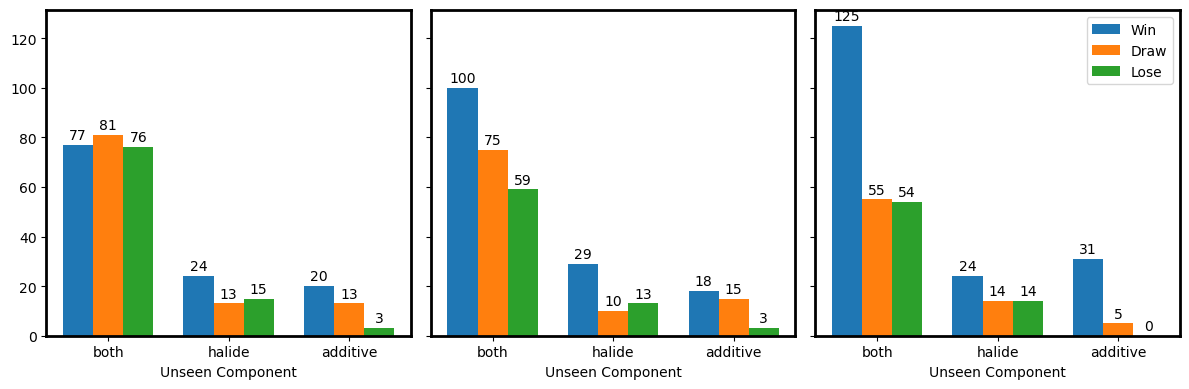

In [5]:
oos_choices = ["both","halide","additive"]

x = np.arange(3)

fig, ax = plt.subplots(ncols=3, figsize=(12,4), tight_layout=True, sharey=True)
for j, model in enumerate(["Pairwise", "LBRF", "LRT"]):
    regressor_w_d_l = np.zeros((3,3))
    for i, row in labelranking_performance_df[labelranking_performance_df["Model"]==model].iterrows():
        halide = row["Test halide"]
        additive = row["Test additive"]
        oos = row["OOS"]

        rpc_top_rank = row["Top Rank"]
        regressor_top_rank = regressor_performance_df[
            (regressor_performance_df["Test halide"] == halide) &\
            (regressor_performance_df["Test additive"] == additive) &\
            (regressor_performance_df["OOS"] == oos)
        ]["Top Rank"].values
        assert len(regressor_top_rank) ==1
        regressor_top_rank = regressor_top_rank[0]
        # print(rpc_top_rank, regressor_top_rank)

        if regressor_top_rank < rpc_top_rank :
            regressor_w_d_l[oos_choices.index(oos), 0] += 1
        elif regressor_top_rank == rpc_top_rank :
            regressor_w_d_l[oos_choices.index(oos), 1] += 1
        else : 
            regressor_w_d_l[oos_choices.index(oos), 2] += 1

    width=0.25
    multiplier = 0
    for oos_ind, measure in enumerate(regressor_w_d_l) :
        offset = width * multiplier
        rects = ax[j].bar(x + offset, regressor_w_d_l[:, oos_ind].flatten(), width)
        ax[j].bar_label(rects, padding=2)
        multiplier += 1
    ax[j].set_xticks(x+width, oos_choices)
    ax[j].set_xlabel("Unseen Component")
    if j == 2 :
        ax[j].legend(["Win", "Draw", "Lose"], loc="upper right")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[j].spines[axis].set_linewidth(2)

In [6]:
regressor_performance_df = pd.read_excel("performance_excels/regressor_performance_20.xlsx")
labelranking_performance_df = pd.read_excel("performance_excels/rpc_performance_20.xlsx")
baseline_performance_df = pd.read_excel("performance_excels/baseline_performance_20.xlsx")

swarmplot_dict = {
    "Model":[],
    "RFR":[],
    "Count":[],
    "OOS":[]
}
baseline_dict = {
    "RFR":[],
    "Count":[],
    "OOS":[]
}
train_halide_additive_pairs = list(set([(x,y) for (x,y) in list(labelranking_performance_df[["Train halides", "Train additives"]].itertuples(index=False, name=None))]))
print(len(train_halide_additive_pairs))
# uniq_train_halides = labelranking_performance_df["Train halides"].unique()
# uniq_train_additives = labelranking_performance_df["Train additives"].unique()

for j, model in enumerate(["Pairwise", "LBRF", "LRT"]):
    for (halide_tuple, additive_tuple) in train_halide_additive_pairs:
        category_counts = np.zeros((3,3)) # each row: OOS / each col: win, draw, lose
        baseline_counts = np.zeros((3,3))
        for i, row in labelranking_performance_df[
            (labelranking_performance_df["Model"]==model) &\
            (labelranking_performance_df["Train halides"]==halide_tuple) &\
            (labelranking_performance_df["Train additives"]==additive_tuple)
        ].iterrows():
            halide = row["Test halide"]
            additive = row["Test additive"]
            oos = row["OOS"]

            lr_top_rank = row["Top Rank"]
            regressor_top_rank = regressor_performance_df[
                (regressor_performance_df["Test halide"] == halide) &\
                (regressor_performance_df["Test additive"] == additive) &\
                (regressor_performance_df["OOS"] == oos)&\
                (regressor_performance_df["Train halides"]==halide_tuple) &\
                (regressor_performance_df["Train additives"]==additive_tuple)
            ]["Top Rank"].values
            baseline_top_rank = baseline_performance_df[
                (baseline_performance_df["Test halide"] == halide) &\
                (baseline_performance_df["Test additive"] == additive) &\
                (baseline_performance_df["OOS"] == oos)&\
                (baseline_performance_df["Train halides"]==halide_tuple) &\
                (baseline_performance_df["Train additives"]==additive_tuple)
            ]["Top Rank"].values
            assert len(regressor_top_rank) == 1
            regressor_top_rank = regressor_top_rank[0]
            baseline_top_rank = baseline_top_rank[0]
            # print(rpc_top_rank, regressor_top_rank)

            if regressor_top_rank < lr_top_rank :
                category_counts[oos_choices.index(oos), 0] += 1
            elif regressor_top_rank == lr_top_rank :
                category_counts[oos_choices.index(oos), 1] += 1
            else : 
                category_counts[oos_choices.index(oos), 2] += 1

            if regressor_top_rank < baseline_top_rank :
                baseline_counts[oos_choices.index(oos), 0] += 1
            elif regressor_top_rank == baseline_top_rank :
                baseline_counts[oos_choices.index(oos), 1] += 1
            else : 
                baseline_counts[oos_choices.index(oos), 2] += 1

        swarmplot_dict["Model"].extend([model]*9)
        swarmplot_dict["RFR"].extend(["Win", "Draw", "Lose"]*3)
        swarmplot_dict["Count"].extend(list(category_counts.flatten()))
        swarmplot_dict["OOS"].extend(["both","both","both","halide","halide","halide","additive","additive","additive"])

        baseline_dict["RFR"].extend(["Win", "Draw", "Lose"]*3)
        baseline_dict["Count"].extend(list(baseline_counts.flatten()))
        baseline_dict["OOS"].extend(["both","both","both","halide","halide","halide","additive","additive","additive"])

20


/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


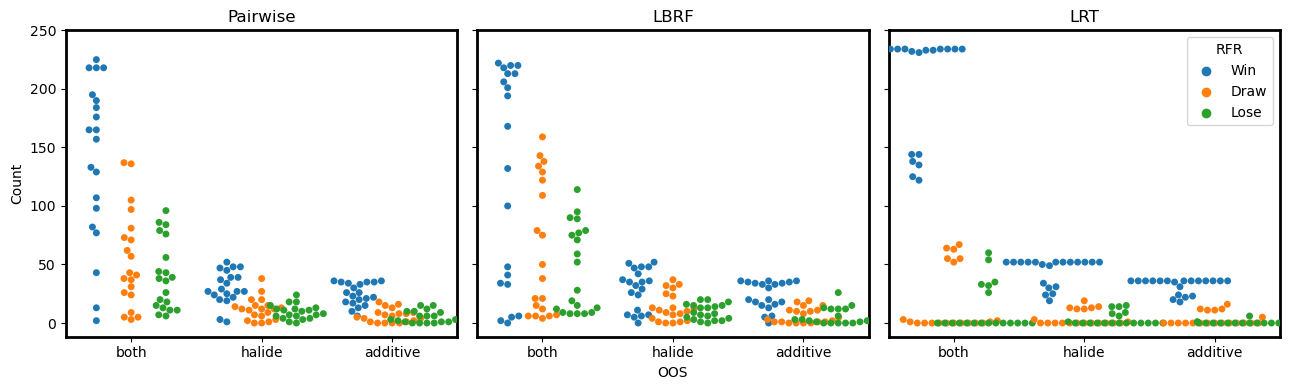

In [7]:
swarmplot_df = pd.DataFrame(swarmplot_dict)

fig, ax = plt.subplots(ncols=3, sharey=True, tight_layout=True, figsize=(13,4))
for j, model in enumerate(["Pairwise", "LBRF", "LRT"]):
    if j!=2 : legend=False
    else : legend=True
    sns.swarmplot(
        data=swarmplot_df.loc[swarmplot_df["Model"]==model, :],
        x="OOS",
        y="Count",
        hue="RFR",
        dodge=True,
        legend=legend,
        ax=ax[j]
    )
    ax[j].set_yticks([50*x for x in np.arange(6)])
    ax[j].set_title(model)
    if j == 0 :
        ax[j].set_yticklabels([50*x for x in np.arange(6)])
    if j!=1 :
        ax[j].set_xlabel("")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[j].spines[axis].set_linewidth(2)

In [9]:
top_ranks_by_oos = [np.zeros((3,234,20)), np.zeros((3,52,20)), np.zeros((3,36,20))] # first axis : models // second axis : test reactant pair // third axis : training dataset

for k, (halide_tuple, additive_tuple) in enumerate(train_halide_additive_pairs):
    oos_counts = [0, 0, 0]    
    for j, row in regressor_performance_df[
        (regressor_performance_df["Train halides"]==halide_tuple) &\
        (regressor_performance_df["Train additives"]==additive_tuple)
    ].iterrows():
        halide = row["Test halide"]
        additive = row["Test additive"]
        oos = row["OOS"]
        top_ranks = [row["Top Rank"]] # in the order of RF, Pairwise, LBRF
        for i, model in enumerate(["Pairwise", "LBRF"]):
            top_ranks.append(labelranking_performance_df[
                (labelranking_performance_df["Test halide"] == halide) &\
                (labelranking_performance_df["Test additive"] == additive) &\
                (labelranking_performance_df["OOS"] == oos)&\
                (labelranking_performance_df["Train halides"]==halide_tuple) &\
                (labelranking_performance_df["Train additives"]==additive_tuple)&\
                (labelranking_performance_df["Model"]==model)
            ]["Top Rank"].values[0])
        top_ranks_by_oos[oos_choices.index(oos)][:,oos_counts[oos_choices.index(oos)],k] = np.array(top_ranks)
        oos_counts[oos_choices.index(oos)] += 1

In [10]:
from scipy.stats import friedmanchisquare

for i, top_rank_array in enumerate(top_ranks_by_oos) :
    avg = np.mean(top_rank_array, axis=1)
    print(avg.shape)
    _, p = friedmanchisquare(avg[0,:].flatten(), avg[1,:].flatten(), avg[2,:].flatten())
    print(p)
    print()


(3, 20)
0.14227407158651317

(3, 20)
0.001580522168736213

(3, 20)
6.175672433276865e-05



/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


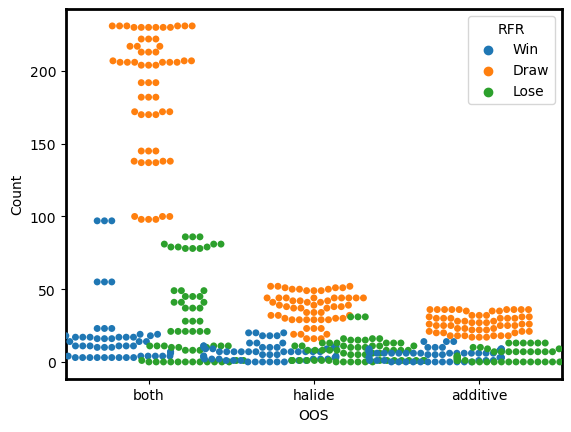

In [12]:
baseline_vs_regressor_df = pd.DataFrame(baseline_dict)

fig, ax = plt.subplots()
sns.swarmplot(
    data=baseline_vs_regressor_df,
    x="OOS",
    y="Count",
    hue="RFR",
    dodge=True,
    legend=legend,
)
# ax[j].set_yticks([50*x for x in np.arange(6)])
# ax[j].set_title(model)
# if j == 0 :
#     ax[j].set_yticklabels([50*x for x in np.arange(6)])
# if j!=1 :
#     ax[j].set_xlabel("")
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

# Visualization of datset

In [2]:
from evaluate_complete_doyle import *

raw_data = pd.read_csv(
    "datasets/doyle_data/Doyle_raw_data.csv",
    usecols=["aryl_halide", "ligand", "base", "additive", "yield"],
)
org_data = pd.pivot_table(
    raw_data,
    values="yield",
    index=["aryl_halide", "additive"],
    columns=["ligand", "base"],
)
# Putting 0% yield as results for those missing results
org_data.fillna(0, inplace=True)

In [3]:
len(raw_data["aryl_halide"].unique()), len(raw_data["additive"].unique())

(16, 24)

In [4]:
single_base_data = pd.pivot_table(
    raw_data,
    values="yield",
    index=["aryl_halide", "additive", "ligand", ],
    columns=["base"],
)
print(single_base_data.columns)
# MTBD rankings
mtbd_rankings = yield_to_ranking(single_base_data.to_numpy())[:,1]
print([len(np.where(mtbd_rankings==x)[0]) for x in range(1,4)])

Index(['BTMG', 'MTBD', 'P2Et'], dtype='object', name='base')
[934, 290, 156]


### Trying to see if using a subset of reaction conditions give harder problem

In [35]:
sub_base_df = raw_data[raw_data["base"].isin(["BTMG", "P2Et"])]
sub_df = sub_base_df[sub_base_df["ligand"].isin(["t-BuBrettPhos", "t-BuXPhos"])] # no yield values are nan "AdBrettPhos", 
print(sub_df.shape)
sub_df = sub_df.dropna()
print(sub_df.shape)

(1530, 5)
(1375, 5)


In [53]:
catalysts = [ "t-BuBrettPhos", "t-BuXPhos"] #"AdBrettPhos",
bases = ["BTMG", "P2Et"]

# don't want reactions that give all below 10%
all_below_ten = []
rank_by_condition = -1 * np.ones((15, 23))
for i, halide in enumerate(sub_df["aryl_halide"].unique()) :
    for j, additive in enumerate(sub_df["additive"].unique()) :
        y_vals = np.zeros(len(catalysts)*len(bases))
        for k, catalyst in enumerate(catalysts) :
            for l, base in enumerate(bases) :
                val = raw_data[ 
                    (raw_data["aryl_halide"]==halide) &\
                    (raw_data["additive"]==additive) &\
                    (raw_data["ligand"]==catalyst) &\
                    (raw_data["base"]==base)
                ]["yield"].values
                if len(val)!= 1 : val = 0
                elif len(val) == 1 : val = val[0]
                y_vals[2*k+l] = val
        if np.all(y_vals < 10) :
            all_below_ten.append((i,j))
        else :
            rank_by_condition[i,j] = np.argmin(yield_to_ranking(y_vals))
        # print(y_vals)

In [55]:
sub_df["aryl_halide"].unique()

array(['1-chloro-4-(trifluoromethyl)benzene',
       '1-bromo-4-(trifluoromethyl)benzene',
       '1-iodo-4-(trifluoromethyl)benzene', '1-chloro-4-methoxybenzene',
       '1-bromo-4-methoxybenzene', '1-iodo-4-methoxybenzene',
       '1-chloro-4-ethylbenzene', '1-bromo-4-ethylbenzene',
       '1-ethyl-4-iodobenzene', '2-chloropyridine', '2-bromopyridine',
       '2-iodopyridine', '3-chloropyridine', '3-bromopyridine',
       '3-iodopyridine'], dtype=object)

<Axes: >

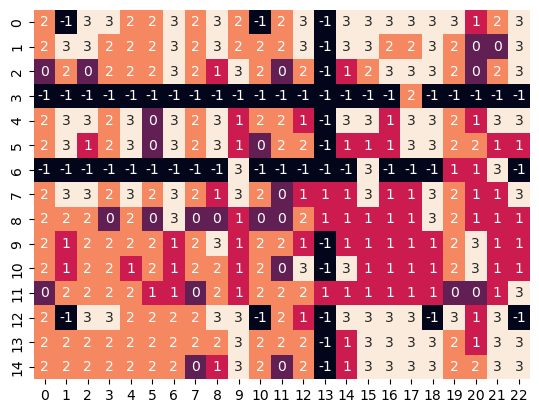

In [54]:
sns.heatmap(rank_by_condition , cbar=False, annot=True)

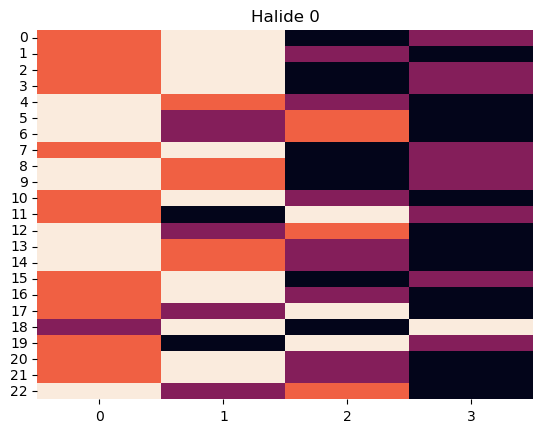

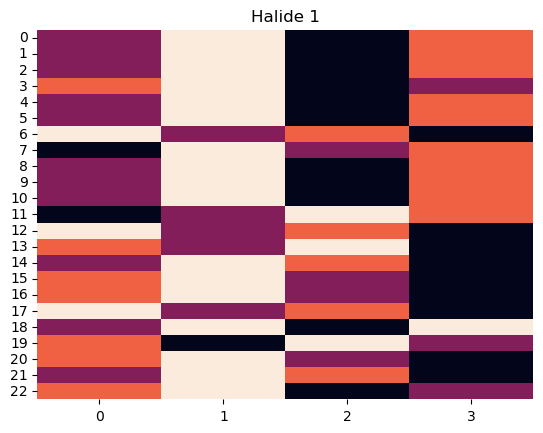

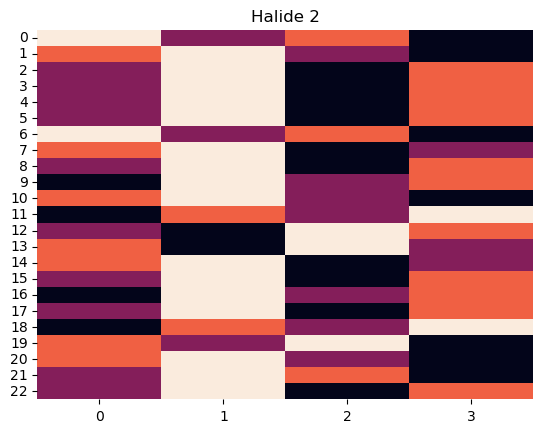

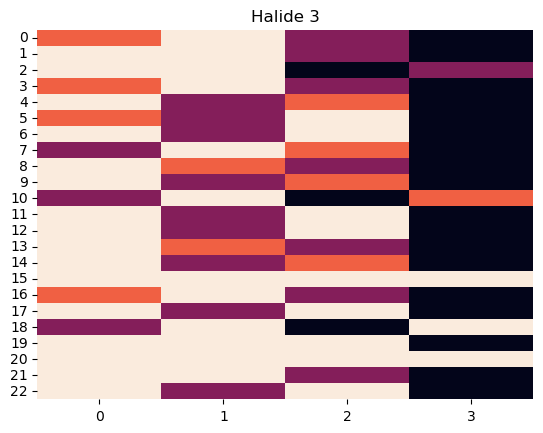

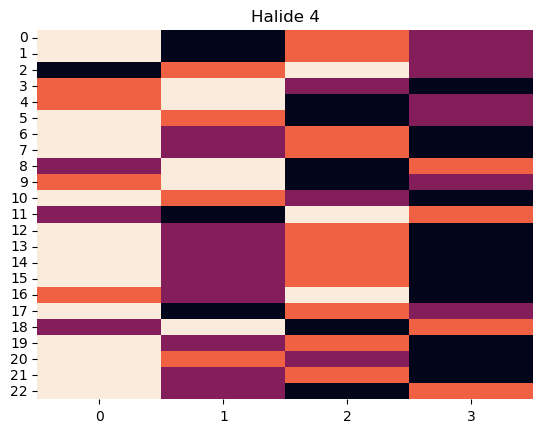

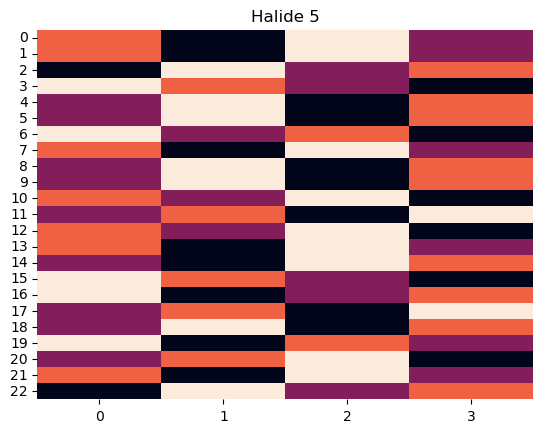

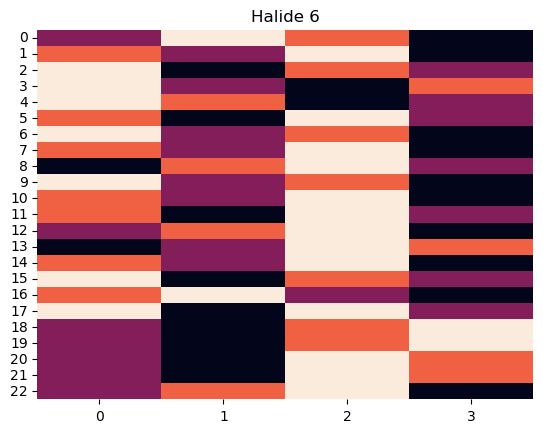

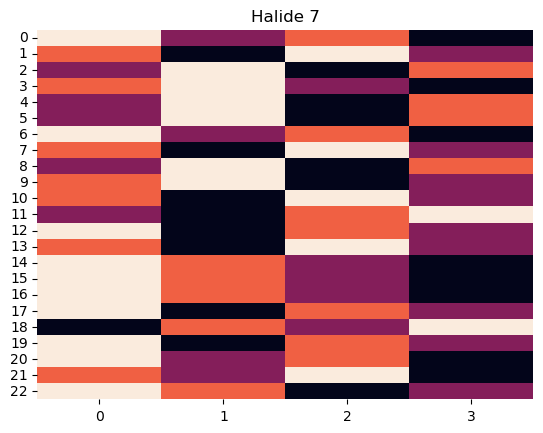

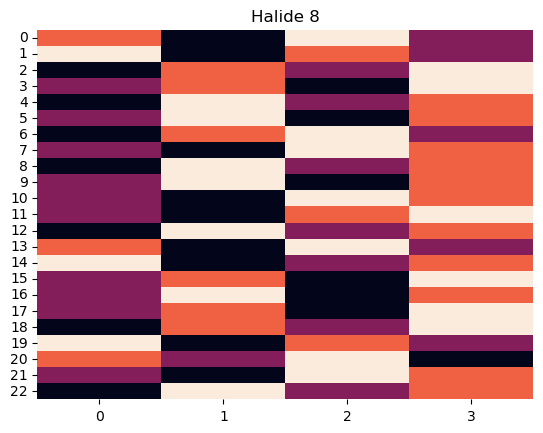

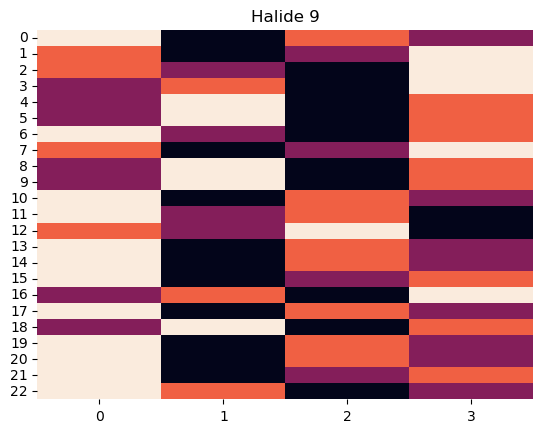

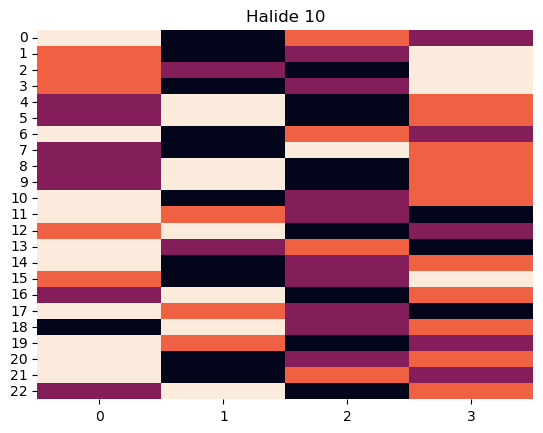

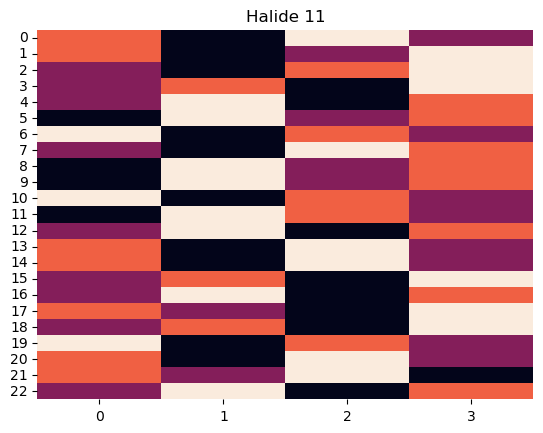

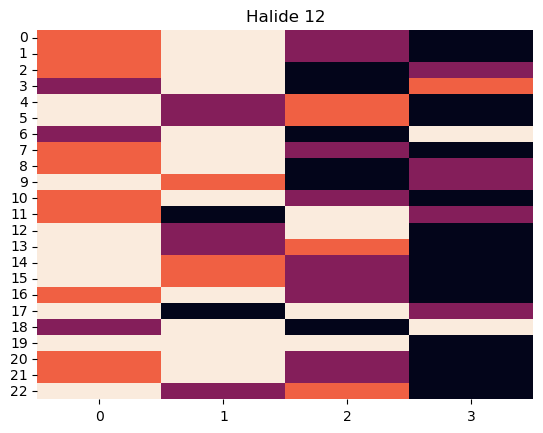

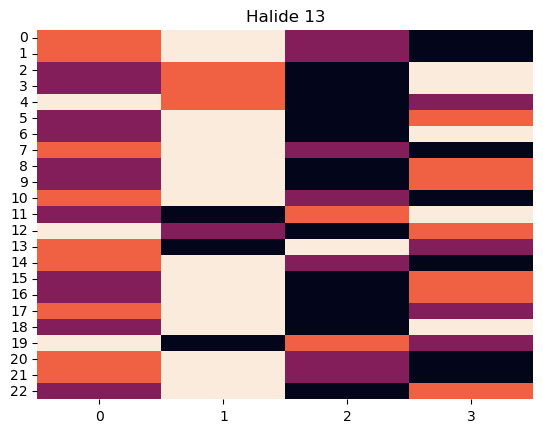

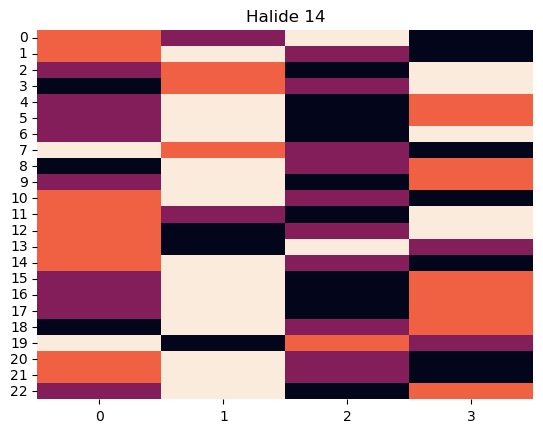

In [37]:
from collections import Counter
for i, halide in enumerate(sub_df["aryl_halide"].unique()) :
    halide_sub_df = sub_df[sub_df["aryl_halide"]==halide]
    rank_array = yield_to_ranking(
        pd.pivot_table(
            halide_sub_df,
            values="yield",
            index=["additive"],
            columns=["ligand", "base"],
        ).to_numpy()
    )
    # print(rank_array.shape)
    # print(f"Halide {i} ({halide})")
    # print(Counter(np.argmin(rank_array, axis=1)))
    # print()
    sns.heatmap(rank_array, cbar=False)
    plt.title(f"Halide {i}")
    plt.show()

In [31]:
halide_sub_df

,base,ligand,aryl_halide,additive,yield
254,P2Et,t-BuXPhos,3-iodopyridine,5-phenylisoxazole,28.589648
270,BTMG,t-BuXPhos,3-iodopyridine,5-phenylisoxazole,86.003404
302,P2Et,t-BuXPhos,3-iodopyridine,ethyl-3-methylisoxazole-5-carboxylate,72.630649
318,BTMG,t-BuXPhos,3-iodopyridine,ethyl-3-methylisoxazole-5-carboxylate,82.137375
350,P2Et,t-BuXPhos,3-iodopyridine,ethyl-5-methylisoxazole-3-carboxylate,69.089044
...,...,...,...,...,...
4485,BTMG,AdBrettPhos,3-iodopyridine,"N,N-dibenzylisoxazol-5-amine",59.162165
4517,P2Et,AdBrettPhos,3-iodopyridine,5-methyl-3-(1H-pyrrol-1-yl)isoxazole,65.678961
4533,BTMG,AdBrettPhos,3-iodopyridine,5-methyl-3-(1H-pyrrol-1-yl)isoxazole,62.559565
4565,P2Et,AdBrettPhos,3-iodopyridine,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,45.770461


In [20]:
sum(sub_df["yield"].isna())

0

In [12]:
len(sub_df["aryl_halide"].unique())

15

In [16]:
len(sub_base_df["ligand"].unique())

4

In [15]:
len(sub_df["aryl_halide"].unique())

15

In [27]:
single_cat_data = pd.pivot_table(
    raw_data,
    values="yield",
    index=["aryl_halide", "additive", "base", ],
    columns=["ligand"],
)
single_cat_rank = yield_to_ranking(single_cat_data.to_numpy())
for i in range(4):
    cat_rankings = single_cat_rank[:,i]
    print(single_cat_data.columns[i])
    print([len(np.where(cat_rankings==x)[0]) for x in range(1,5)])
    print()

rank_count = {x:0 for x in permutations(range(1,5))}
for rank_row in single_cat_rank :
    if tuple(rank_row) not in rank_count.keys():
        rank_count[tuple(rank_row)] =1
    else : 
        rank_count[tuple(rank_row)] +=1

# print(rank_count)
print(len(rank_count.keys()))

AdBrettPhos
[132, 194, 429, 280]

XPhos
[53, 124, 119, 739]

t-BuBrettPhos
[245, 432, 248, 110]

t-BuXPhos
[582, 238, 166, 49]

36


[Text(0, 0.5, ''),
 Text(0, 2.5, ''),
 Text(0, 4.5, ''),
 Text(0, 6.5, ''),
 Text(0, 8.5, ''),
 Text(0, 10.5, ''),
 Text(0, 12.5, ''),
 Text(0, 14.5, ''),
 Text(0, 16.5, ''),
 Text(0, 18.5, ''),
 Text(0, 20.5, ''),
 Text(0, 22.5, ''),
 Text(0, 24.5, ''),
 Text(0, 26.5, ''),
 Text(0, 28.5, ''),
 Text(0, 30.5, ''),
 Text(0, 32.5, ''),
 Text(0, 34.5, ''),
 Text(0, 36.5, ''),
 Text(0, 38.5, ''),
 Text(0, 40.5, ''),
 Text(0, 42.5, ''),
 Text(0, 44.5, ''),
 Text(0, 46.5, ''),
 Text(0, 48.5, ''),
 Text(0, 50.5, ''),
 Text(0, 52.5, ''),
 Text(0, 54.5, ''),
 Text(0, 56.5, ''),
 Text(0, 58.5, ''),
 Text(0, 60.5, ''),
 Text(0, 62.5, ''),
 Text(0, 64.5, ''),
 Text(0, 66.5, ''),
 Text(0, 68.5, ''),
 Text(0, 70.5, ''),
 Text(0, 72.5, ''),
 Text(0, 74.5, ''),
 Text(0, 76.5, ''),
 Text(0, 78.5, ''),
 Text(0, 80.5, ''),
 Text(0, 82.5, ''),
 Text(0, 84.5, ''),
 Text(0, 86.5, ''),
 Text(0, 88.5, ''),
 Text(0, 90.5, ''),
 Text(0, 92.5, ''),
 Text(0, 94.5, ''),
 Text(0, 96.5, ''),
 Text(0, 98.5, ''),
 Text

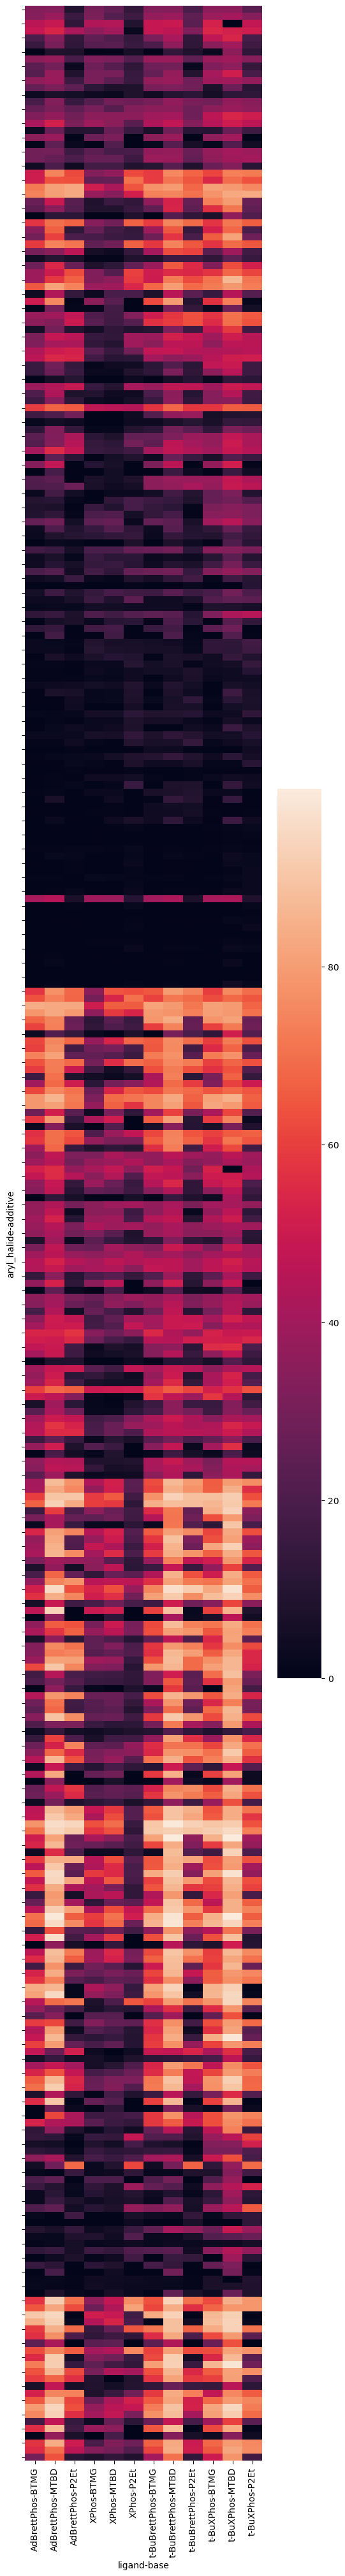

In [43]:
fig, ax = plt.subplots(figsize=(6,50))
sns.heatmap(org_data)
ax.set_yticklabels([])


In [15]:
yield_to_ranking(org_data_array)

array([[ 6,  3, 12, ...,  2,  1,  9],
       [ 7,  4, 12, ...,  2,  1,  6],
       [ 6,  3, 10, ...,  1, 12,  5],
       ...,
       [ 7,  1,  8, ...,  5,  3,  4],
       [ 7,  4,  9, ...,  5,  2,  3],
       [ 6,  3, 10, ...,  4,  1,  7]])

In [58]:
rank_array = yield_to_ranking(org_data_array)
portion_top_2 = []
for i in range(12) :
    portion_top_2.append(100*len(np.where(rank_array[:,i] <= 2)[0])/345)

print(portion_top_2)
print(sum(portion_top_2))

Raw rank (345, 12)
[0.2898550724637681, 33.04347826086956, 5.507246376811594, 0.8695652173913043, 0.2898550724637681, 7.536231884057971, 0.8695652173913043, 50.14492753623188, 5.217391304347826, 12.173913043478262, 66.66666666666667, 16.52173913043478]
199.13043478260872
